## Notebook to show how to use redback to generate toO style observations for any model. 

You will need to install Redback. Instructions available at https://redback.readthedocs.io/en/latest/. I suggest installing from source via GitHub.

In [1]:
import redback
import pandas as pd
from redback.simulate_transients import SimulateOpticalTransient
import matplotlib.pyplot as plt
import numpy as np

16:21 bilby INFO    : Running bilby version: 2.2.4.dev7+ga818fe8f
16:21 redback INFO    : Running redback version: 1.0.1


We first design a strategy. This takes the form of a dataframe which specifies sky pointings, time, limiting mags, and the bands

In [2]:
# specify the number of pointings per band 
num_obs = {'lsstg': 10, 'lsstr':10, 'lssti':10, 'lsstz':10, 'lsstu':10}

# specify the cadence in days for each band
average_cadence = {'lsstg': 1.5, 'lsstr': 5.0, 'lssti': 2.5, 'lsstz':1, 'lsstu':1}

# specify any scatter on the cadence, the time of the observation will be 
# taken from a Gaussian with the scatter as sigma
cadence_scatter = {'lsstg': 0.5, 'lsstr':0.5, 'lssti':0.5, 'lsstz':1, 'lsstu':1}

# Specify limiting 5 sigma depth magnitude
limiting_magnitudes = {'lsstg': 25.0, 'lsstr': 24.5, 'lssti': 23.0, 'lsstu':25, 'lsstz':23}

# We now use redback to make a pointings table from the above information
# We set RA and DEC to always be at the location of the transient 
# but we can change this to incorporate the fov/full survey
ra = 1.0 
dec = 1.5
# We also set the start time of the observation/survey strategy 
initMJD = 59581.0
pointings = redback.simulate_transients.make_pointing_table_from_average_cadence(
    ra=ra, dec=dec, num_obs=num_obs, average_cadence=average_cadence,
    cadence_scatter=cadence_scatter, limiting_magnitudes=limiting_magnitudes, 
    initMJD=59581.0)
print(pointings)

         expMJD  _ra  _dec filter  fiveSigmaDepth
0  59581.159691  1.0   1.5  lsstu            25.0
0  59581.946681  1.0   1.5  lsstz            23.0
2  59582.083415  1.0   1.5  lsstz            23.0
3  59582.182805  1.0   1.5  lsstz            23.0
4  59582.200933  1.0   1.5  lsstz            23.0
1  59582.625793  1.0   1.5  lsstz            23.0
0  59582.915693  1.0   1.5  lsstg            25.0
1  59583.087919  1.0   1.5  lsstu            25.0
2  59583.227214  1.0   1.5  lsstu            25.0
7  59583.639468  1.0   1.5  lsstz            23.0
0  59583.938204  1.0   1.5  lssti            23.0
6  59584.255173  1.0   1.5  lsstz            23.0
8  59584.489534  1.0   1.5  lsstz            23.0
5  59584.631016  1.0   1.5  lsstz            23.0
3  59584.843276  1.0   1.5  lsstu            25.0
1  59585.520656  1.0   1.5  lsstg            25.0
9  59585.754989  1.0   1.5  lsstz            23.0
0  59585.789345  1.0   1.5  lsstr            24.5
1  59586.814794  1.0   1.5  lssti            23.0


We now specify a redback model (or a user implemented model) and the parameters we want to simulate given the above cadences. 

In [3]:
model_kwargs = {}
# Any redback model can be referred to as a string. 
# If the user has their own model, they can pass a function here instead. 
# There are over a 100 models implemented in redback, many for kilonovae, GRB afterglows, supernovae, TDEs and other things
model = 'one_component_kilonova'
# Load the default prior for this model in redback and sample from it to get 1 set of parameters. 
# We can sample from the default prior for this model for a random kilonova. 
parameters = redback.priors.get_priors(model=model).sample()

# We fix a few parameters here to create a nice looking kilonova
parameters['mej'] = 0.05
parameters['t0_mjd_transient'] = 59582.0
parameters['redshift'] = 0.01
parameters['t0'] = parameters['t0_mjd_transient']
parameters['temperature_floor'] = 3000
parameters['kappa'] = 1
parameters['vej'] = 0.2
parameters['ra'] = 1.0
parameters['dec'] = 1.5
print(parameters)

16:21 redback WARNING : [Errno 2] No such file or directory: '/Users/nikhil/Documents/postdoc/redback/redback/priors/one_component_kilonova.prior'
16:21 redback WARNING : Returning empty PriorDict.


{'mej': 0.05, 't0_mjd_transient': 59582.0, 'redshift': 0.01, 't0': 59582.0, 'temperature_floor': 3000, 'kappa': 1, 'vej': 0.2, 'ra': 1.0, 'dec': 1.5}


We now simulate a kilonova with the above parameters and the strategy designed above.

In [4]:
kn_sim = SimulateOpticalTransient.simulate_transient(model='one_component_kilonova_model',
                                       parameters=parameters, pointings_database=pointings,
                                       survey=None, model_kwargs=model_kwargs,
                                        end_transient_time=20., snr_threshold=5.0)

16:21 redback INFO    : Using the supplied as the pointing database.


In [5]:
# We can print the observations that were simulated to see what the data looks like. 
# This will include extra stuff like non-detections etc
print(kn_sim.observations)

            time  magnitude  e_magnitude   band system  flux_density(mjy)   
0   59581.159691        NaN          NaN  lsstu     AB       3.835527e-14  \
1   59581.946681        NaN          NaN  lsstz     AB       7.034873e-15   
2   59582.083415  21.652528     0.070833  lsstz     AB       7.022943e-03   
3   59582.182805  20.638699     0.024769  lsstz     AB       2.008389e-02   
4   59582.200933  20.507816     0.021948  lsstz     AB       2.266548e-02   
5   59582.625793  19.098374     0.005974  lsstz     AB       8.326845e-02   
6   59582.915693  19.518728     0.001393  lsstg     AB       5.661590e-02   
7   59583.087919  20.635558     0.003875  lsstu     AB       2.034579e-02   
8   59583.227214  20.778616     0.004457  lsstu     AB       1.768781e-02   
9   59583.639468  18.402093     0.003145  lsstz     AB       1.581727e-01   
10  59583.938204  18.642413     0.003909  lssti     AB       1.272728e-01   
11  59584.255173  18.453106     0.003294  lsstz     AB       1.510111e-01   

In [6]:
# We can also save the observations to a file using the save_transient method.
# This will save the observations to a csv file in a 'simulated' directory alongside the csv file
# specifying the injection parameters.
kn_sim.save_transient(name='my_kilonova')

16:21 redback WARNING : [Errno 2] No such file or directory: 'kilonova//my_kilonova_metadata.csv'
16:21 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


(24.0, 18.0)

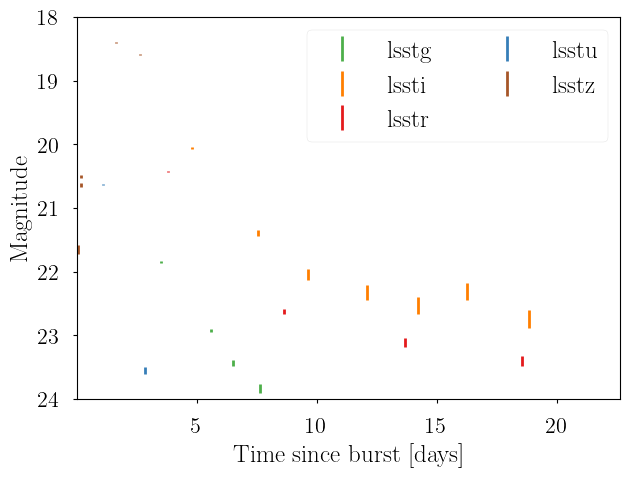

In [7]:
kn_object = redback.transient.Kilonova.from_simulated_optical_data(name='my_kilonova', data_mode='magnitude')

# Make a dictionary for colors on the plot
band_colors = {'lsstg':'#4daf4a', 'lsstu':'#377eb8', 'lsstr':'#e41a1c', 
               'lsstz':'#a65628', 'lssti':'#ff7f00'}
ax = kn_object.plot_data(show=False, band_colors=band_colors)
ax.set_ylim(24, 18)

The above plot only shows the detection and not the input lightcurve or non-detections. Let's add those in. As the axes is returned with can use the attributes stored in the kn_sim object directly.

(0.1, 20.0)

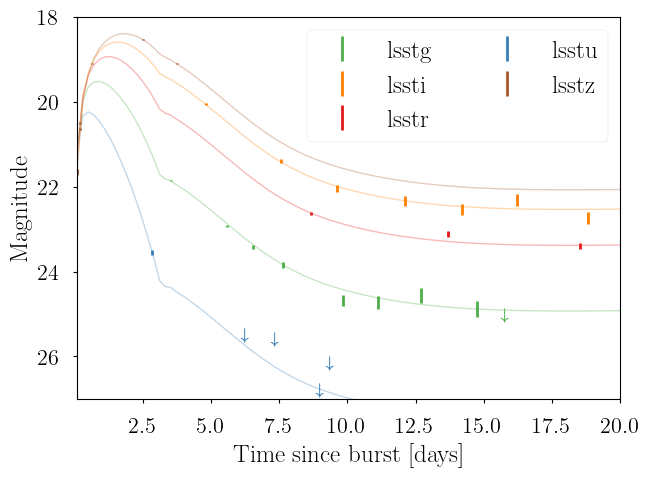

In [8]:
# Make a dictionary for colors on the plot
band_colors = {'lsstg':'#4daf4a', 'lsstu':'#377eb8', 'lsstr':'#e41a1c', 
               'lsstz':'#a65628', 'lssti':'#ff7f00'}
ax = kn_object.plot_data(show=False, band_colors=band_colors)
ax.set_ylim(27, 18)

upper_limits = kn_sim.observations[kn_sim.observations['detected'] != 1.0]

for band in band_colors.keys():
    up = upper_limits[upper_limits['band'] == band]
    plt.scatter(up['time (days)'], up['magnitude'], s=100, marker=r'$\downarrow$', color=band_colors[band])

    
# We can also plot the true data 
tt = np.linspace(0.1, 20, 100)
# specify output_format 
parameters['output_format'] = 'magnitude'
for band in band_colors.keys():
    parameters['bands'] = band
    out = redback.transient_models.kilonova_models.one_component_kilonova_model(tt, **parameters)
    plt.plot(tt, out, color=band_colors[band], alpha=0.3)

plt.xlim(0.1, 20)


You can now use the simulated object and do parameter estimation. There are multiple examples available at 
https://github.com/nikhil-sarin/redback/tree/master/examples. Alongside other examples to simulate full survey or single lightcurves for Rubin or ZTF 
https://github.com/nikhil-sarin/redback/blob/master/examples/simulate_survey.py
https://github.com/nikhil-sarin/redback/blob/master/examples/simulate_single_transient_in_rubin.py
